In [26]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
#from google.colab import drive

#drive.mount('/content/drive')

In [104]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv', dtype='int') # load a dataframe with the siabetes health indicators dataset

Text(0.5, 1.0, 'Correlation matrix of features')

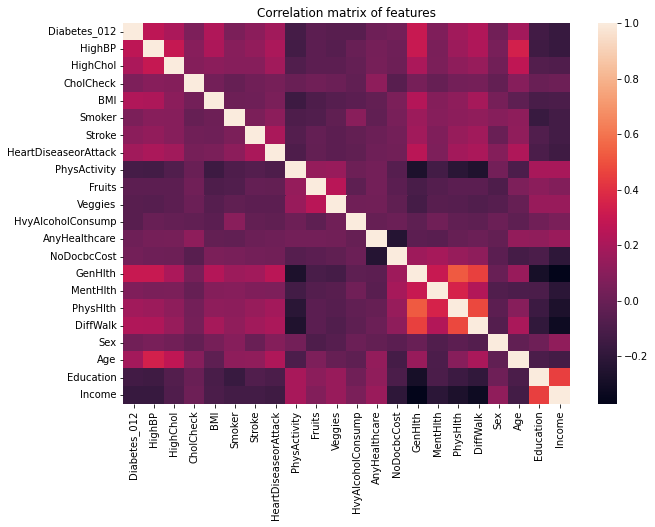

In [105]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(corr)
plt.title("Correlation matrix of features")

In [106]:
corr['Diabetes_012']

Diabetes_012            1.000000
HighBP                  0.271596
HighChol                0.209085
CholCheck               0.067546
BMI                     0.224379
Smoker                  0.062914
Stroke                  0.107179
HeartDiseaseorAttack    0.180272
PhysActivity           -0.121947
Fruits                 -0.042192
Veggies                -0.058972
HvyAlcoholConsump      -0.057882
AnyHealthcare           0.015410
NoDocbcCost             0.035436
GenHlth                 0.302587
MentHlth                0.073507
PhysHlth                0.176287
DiffWalk                0.224239
Sex                     0.031040
Age                     0.185026
Education              -0.130517
Income                 -0.171483
Name: Diabetes_012, dtype: float64

In [107]:
# Most correlated features
diab_corr = corr['Diabetes_012']
high_corr = diab_corr[abs(diab_corr) > 0.2].keys()

print("High correlation columns:", high_corr)

High correlation columns: Index(['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk'], dtype='object')


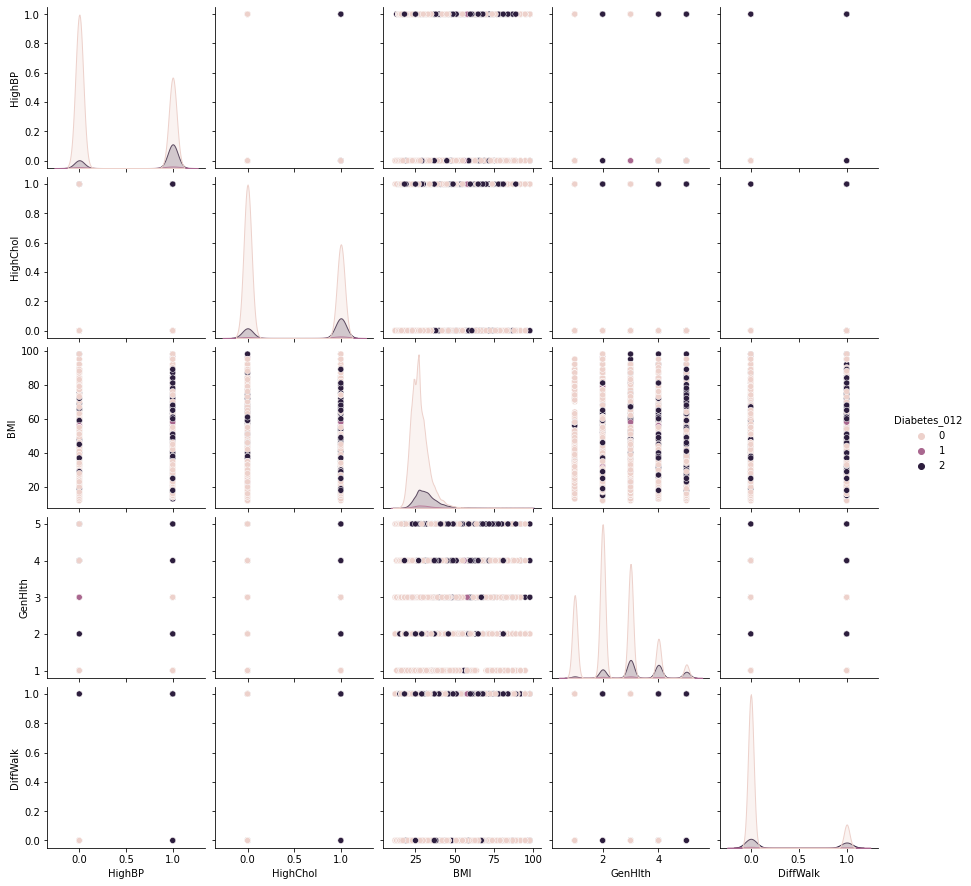

In [108]:
selected_columns = high_corr[1:]

sns.pairplot(data, x_vars = selected_columns, y_vars = selected_columns, hue="Diabetes_012", height=2.5)
plt.show()

In [ ]:
data_x = data.iloc[:,1:].copy() # dataframe of all indicators
data_y = data.iloc[:,0].copy() # datafrma with label - had diametes or no diabetes

In [ ]:
for col in data_x.columns:
    print(col, data_x[col].unique())

HighBP [1 0]
HighChol [1 0]
CholCheck [1 0]
BMI [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
Smoker [1 0]
Stroke [0 1]
HeartDiseaseorAttack [0 1]
PhysActivity [0 1]
Fruits [0 1]
Veggies [1 0]
HvyAlcoholConsump [0 1]
AnyHealthcare [1 0]
NoDocbcCost [0 1]
GenHlth [5 3 2 4 1]
MentHlth [18  0 30  3  5 15 10  6 20  2 25  1  4  7  8 21 14 26 29 16 28 11 12 24
 17 13 27 19 22  9 23]
PhysHlth [15  0 30  2 14 28  7 20  3 10  1  5 17  4 19  6 12 25 27 21 22  8 29 24
  9 16 18 23 13 26 11]
DiffWalk [1 0]
Sex [0 1]
Age [ 9  7 11 10  8 13  4  6  2 12  5  1  3]
Education [4 6 3 5 2 1]
Income [3 1 8 6 4 7 2 5]


We have included all the features for model training since we did not find any significant correlations between the features themselves

### Data Pre-Processing

###### Since BMI ranges from 12 to 98, we can categorize it as 1 - underweight (<18), 2 - healthy (19-24), 3 - overweight (25-29), 4 - obese (30-39), 5 - extremely obese (>39)

In [ ]:
data_x['BMI'] = data_x['BMI'].replace(np.arange(0,19),1).replace(np.arange(19,25),2).replace(np.arange(25, 30),3).replace(np.arange(30, 39), 4).replace(np.arange(39, 99),5)

##### One-hot encode dependent variable 
In some of the models we will build, we would use a one hot-encoded label vector 

In [ ]:
enc = preprocessing.OneHotEncoder().fit(np.array(data_y).reshape([-1,1]))
data_y_ohe = enc.transform(np.array(data_y).reshape([-1,1])).toarray()

### Data Vizualization

#### Number of classes

Number of observations with no diabetes: 213703
Number of observations with pre-diabetes: 4631
Number of observations with diabetes: 35346


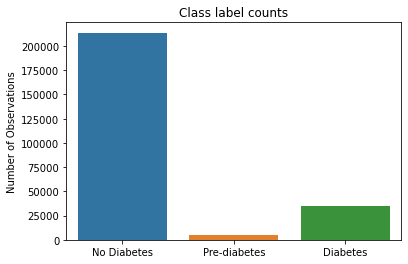

In [ ]:
sns.countplot(x = data_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts')

print('Number of observations with no diabetes:', data_y[data_y==0].count())
print('Number of observations with pre-diabetes:', data_y[data_y==1].count())
print('Number of observations with diabetes:', data_y[data_y==2].count())

There is a class imbalance in the CDC diabetes dataset. The number of pre-diabetes and diabetes cases is relatively very small compared to the no diabetes cohort.

### Train-Test Split, Use test dataset as hold-out set

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y, test_size = 0.1, random_state = 32)

### The most basic model - classify all cases as no-diabetes

If we classify all the observations as no diabetes: 

                                           Predicted
                                  No Diabetes	Pre-diabetes	Diabetes
    
                   No Diabetes      21409	        0       	 0
                   
     Actual        Pre-diabetes     420 	        0	         0

                   Diabetes         3539	        0	         0

In [ ]:
print('Accuracy when we classify all observations as no-diabetes:', metrics.accuracy_score(test_y, np.zeros(len(test_y))))
print('F1-score when we classify all observations as no-diabetes:', metrics.f1_score(test_y, np.zeros(len(test_y)), labels = [0,1,2], average = None))

Accuracy when we classify all observations as no-diabetes: 0.8439372437716809
F1-score when we classify all observations as no-diabetes: [0.91536439 0.         0.        ]


As our goal is to design a model that accurately identifies people at risk of diabetes or who have diabetes, we can readily see from above cells that this naive assumption of classifying everything as no diabetes and then using accuracy to evaluate model is faulty. As it is heavily skewed due to class imbalance. Hence accuracy is not a good metric for evaluating model performance. Instead, we compare the confusion matrices and F1-scores to evaluate model performance. Specifically, we are interested in maximizing recall i.e. the probability of predicting true labels as true.  

#### Randomly classify labels
##### Multi-class

In [ ]:
predict_random = np.random.choice([0,1,2],size = len(test_y))
# Confusion Matrix
cm_random_clf = metrics.confusion_matrix(test_y, predict_random, labels = [0,1,2])
cm_random_clf =  pd.DataFrame(cm_random_clf, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Downsampled \n \n  \033[0m', '\t  \t Predicted')
cm_random_clf

	   Confusion Matrix for Downsampled 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,7092,7185,7132
Pre-diabetes,169,143,161
Diabetes,1178,1163,1145


In [ ]:
print('Accuracy when we classify observations randomly:', metrics.accuracy_score(test_y, predict_random))
print('Precision  when we classify observations randomly:', metrics.precision_score(test_y, predict_random, labels = [0,1,2], average = None))
print('Recall  when we classify observations randomly:', metrics.recall_score(test_y, predict_random, labels = [0,1,2], average = None))
print('F1-score when we classify observations randomly:', metrics.f1_score(test_y, predict_random, labels = [0,1,2], average = None))

Accuracy when we classify observations randomly: 0.3303374329864396
Precision  when we classify observations randomly: [0.84038393 0.01684136 0.13569566]
Recall  when we classify observations randomly: [0.33126255 0.30232558 0.32845668]
F1-score when we classify observations randomly: [0.47520772 0.0319054  0.19204965]


##### Ramdom Binary Classification

In [ ]:
test_binary = test_y.drop(test_y[test_y==1].index).apply(lambda x: 1 if x==2 else 0)
predict_random = np.random.choice([0,1],size = len(test_binary))
# Confusion Matrix
cm_random_clf = metrics.confusion_matrix(test_binary, predict_random, labels = [0,1])
cm_random_clf =  pd.DataFrame(cm_random_clf, columns= ['No Diabetes', 'Diabetes'], index =  ['No Diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Downsampled \n \n  \033[0m', '\t  \t Predicted')
cm_random_clf

	   Confusion Matrix for Downsampled 
 
   	  	 Predicted


,No Diabetes,Diabetes
No Diabetes,10779,10630
Diabetes,1771,1715


In [ ]:
print('Accuracy when we classify observations randomly:', metrics.accuracy_score(test_binary, predict_random))
print('Precision  when we classify observations randomly:', metrics.precision_score(test_binary, predict_random, labels = [0,1], average = None))
print('Recall  when we classify observations randomly:', metrics.recall_score(test_binary, predict_random, labels = [0,1], average = None))
print('F1-score when we classify observations randomly:', metrics.f1_score(test_binary, predict_random, labels = [0,1], average = None))

Accuracy when we classify observations randomly: 0.5018678449487849
Precision  when we classify observations randomly: [0.85888446 0.13892264]
Recall  when we classify observations randomly: [0.50347984 0.49196787]
F1-score when we classify observations randomly: [0.63482435 0.21666351]


These results give us a reference of when a classifier performs random predictions.

### 2 methods of correction of Class Imbalance in the training dataset
##### Downsampling:
 Diabetes and No-Diabetes observations will be downsampled - So randomly select ~4000 observations from each class
##### Upsampling:
 Diabetes and Prediabetes observations will be upsampled - So duplicate the onservations from each class


In [24]:
# Load Downsampled dataset

train_dwn = pd.read_csv('train_data_downsampled.csv')
train_dwn_x = train_dwn.iloc[:,1:] # features
train_dwn_y = train_dwn.iloc[:,0] # labels

# Load Upsampled dataset
train_up = pd.read_csv('train_data_upsampled.csv')
train_up_x = train_up.iloc[:,1:] # features
train_up_y = train_up.iloc[:,0] # labels

# Load test data
test_data = pd.read_csv('test_BMI_processed.csv')
test_x = test_data.iloc[:, 1:]
test_y = test_data.iloc[:, 0]

Number of observations with no diabetes: 4158
Number of observations with pre-diabetes: 4158
Number of observations with diabetes: 4158


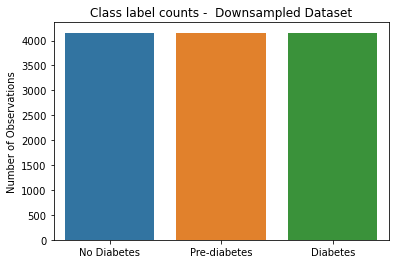

In [ ]:
sns.countplot(x = train_dwn_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts -  Downsampled Dataset')

print('Number of observations with no diabetes:', train_dwn_y.value_counts()[0])
print('Number of observations with pre-diabetes:', train_dwn_y.value_counts()[1])
print('Number of observations with diabetes:', train_dwn_y.value_counts()[2])

Text(0.5, 1.0, 'Correlation matrix of features')

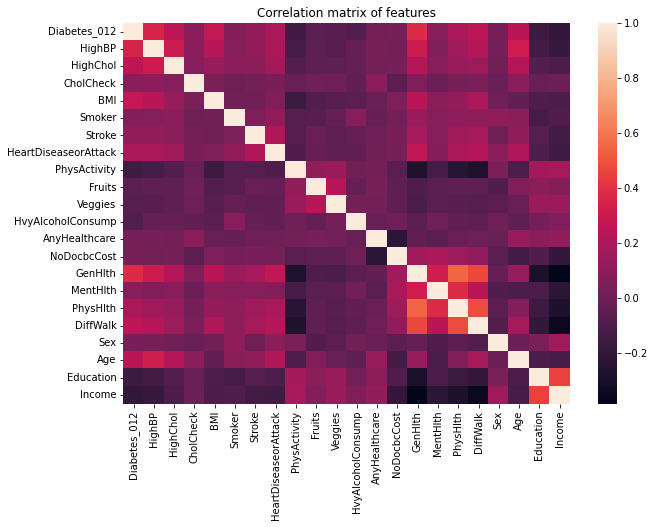

In [100]:
corr = train_dwn.corr()

fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(corr)
plt.title("Correlation matrix of features")

In [101]:
corr['Diabetes_012']

Diabetes_012            1.000000
HighBP                  0.353685
HighChol                0.262678
CholCheck               0.107391
BMI                     0.283472
Smoker                  0.079923
Stroke                  0.119927
HeartDiseaseorAttack    0.198673
PhysActivity           -0.147393
Fruits                 -0.055863
Veggies                -0.067294
HvyAlcoholConsump      -0.086752
AnyHealthcare           0.027662
NoDocbcCost             0.033192
GenHlth                 0.380359
MentHlth                0.081461
PhysHlth                0.199525
DiffWalk                0.256205
Sex                     0.042284
Age                     0.251293
Education              -0.158330
Income                 -0.204949
Name: Diabetes_012, dtype: float64

In [102]:
# Most correlated features
diab_corr = corr['Diabetes_012']
high_corr = diab_corr[abs(diab_corr) > 0.2].keys()

print("High correlation columns:", high_corr)

High correlation columns: Index(['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk',
       'Age', 'Income'],
      dtype='object')


Number of observations with no diabetes: 192294
Number of observations with pre-diabetes: 192294
Number of observations with diabetes: 192294


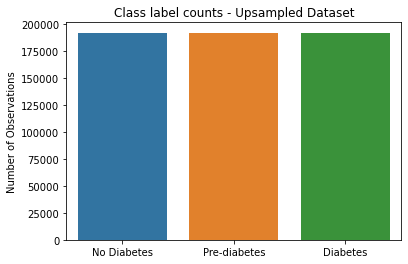

In [ ]:
sns.countplot(x = train_up_y)
plt.xticks([0,1,2], ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Class label counts - Upsampled Dataset')

print('Number of observations with no diabetes:', train_up_y.value_counts()[0])
print('Number of observations with pre-diabetes:', train_up_y.value_counts()[1])
print('Number of observations with diabetes:', train_up_y.value_counts()[2])

### Evaluate performance of baseline Model - Logistic Regression - using downsampled and upsampled training dataset

## Logistic Regression - multi-class - downsampled dataset

In [70]:
logistic_clf_model_dwn = LogisticRegression(multi_class = 'ovr', max_iter=10000)
logistic_clf_model_dwn.fit(train_dwn_x,train_dwn_y) # train logistic regression on training data using one vs rest
logistic_clf_dwn_predict = logistic_clf_model_dwn.predict(test_x)

##### model performance on test set

In [ ]:
# downsampled
cm_logistic_clf_dwn = metrics.confusion_matrix(test_y, logistic_clf_dwn_predict, labels = [0,1,2])
cm_logistic_clf_dwn =  pd.DataFrame(cm_logistic_clf_dwn, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Downsampled \n \n  \033[0m', '\t  \t Predicted')
cm_logistic_clf_dwn

	   Confusion Matrix for Downsampled 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,14543,3042,3824
Pre-diabetes,124,126,223
Diabetes,668,719,2099


## Logistic Regression - multi-class - Upsampled dataset

In [ ]:
logistic_clf_model_up = LogisticRegression(multi_class = 'ovr', max_iter=10000)
logistic_clf_model_up.fit(train_up_x,train_up_y) # train logistic regression on training data using one vs rest
logistic_clf_up_predict = logistic_clf_model_up.predict(test_x)

##### model performance on test set

In [ ]:
# Upsampled
cm_logistic_clf_up = metrics.confusion_matrix(test_y, logistic_clf_up_predict, labels = [0,1,2])
cm_logistic_clf_up =  pd.DataFrame(cm_logistic_clf_up, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Upsampled \n \n  \033[0m', '\t  \t Predicted')
cm_logistic_clf_up

	   Confusion Matrix for Upsampled 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,14581,2929,3899
Pre-diabetes,120,123,230
Diabetes,658,694,2134


## Comparing  performance of Logistic Regression models trained on UpSampled and DownSampled Data

In [ ]:
print('Model trained on Downsampled Data \n')
print('Precision for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))
print('Recall for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))
print('F1-score for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, logistic_clf_dwn_predict, labels = [0,1,2], average = None))

print('\n \nModel trained on Upsampled Data\n')
print('Precision for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))
print('Recall for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))
print('F1-score for logistic regression classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, logistic_clf_up_predict, labels = [0,1,2], average = None))

Model trained on Downsampled Data 

Precision for logistic regression classifier for predicting 0, 1, 2 labels: [0.94835344 0.03241574 0.34152294]
Recall for logistic regression classifier for predicting 0, 1, 2 labels: [0.67929375 0.26638478 0.60212278]
F1-score for logistic regression classifier for predicting 0, 1, 2 labels: [0.79158502 0.05779817 0.43583887]

 
Model trained on Upsampled Data

Precision for logistic regression classifier for predicting 0, 1, 2 labels: [0.94934566 0.03283502 0.34073128]
Recall for logistic regression classifier for predicting 0, 1, 2 labels: [0.68106871 0.26004228 0.61216294]
F1-score for logistic regression classifier for predicting 0, 1, 2 labels: [0.79313534 0.05830766 0.43778849]


On comparing the two models we can see that the model trained on Upsampled data performs better than the model trained on downsampled data by a very small fraction < 1 %. Hence, we chose to train the remaining models supervised - KNN, Random Forest, Ada Boost, SVM - on the downsampled data to save computation time.

## K Nearest Neighbors

In [ ]:
# split downsampled data into train and validation
train_x_small, val_x, train_y_small, val_y = train_test_split(train_dwn_x, train_dwn_y, test_size = 0.1, random_state = 32)

In [ ]:
acc_val_knn = []
train_acc = []
for k in np.arange(1, 60, 5):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y))# compute accuracy of predictiosn on validation set
    train_acc.append(KNN_model.score(train_x_small, train_y_small))# compute accuracy of predictiosn on train set

Text(0, 0.5, 'Accuracy')

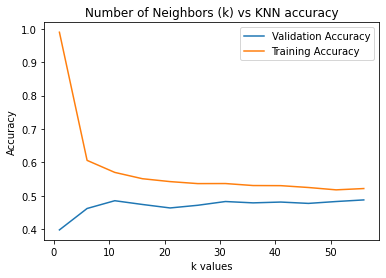

In [ ]:
plt.plot(np.arange(1, 60, 5), acc_val_knn)
plt.plot(np.arange(1, 60, 5), train_acc)
plt.title('Number of Neighbors (k) vs KNN accuracy')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('k values')
plt.ylabel('Accuracy')

We can see that the optimal K value is somewhere between 1 and 12

In [ ]:
acc_val_knn = []
train_acc = []
for k in np.arange(1, 14, 2):
    KNN_model = KNN(n_neighbors = k)
    KNN_model.fit(train_x_small, train_y_small)
    acc_val_knn.append(KNN_model.score(val_x, val_y)) # compute accuracy of predictiosn on validation set
    train_acc.append(KNN_model.score(train_x_small, train_y_small))# compute accuracy of predictiosn on train set

Text(0, 0.5, ' Validation Accuracy')

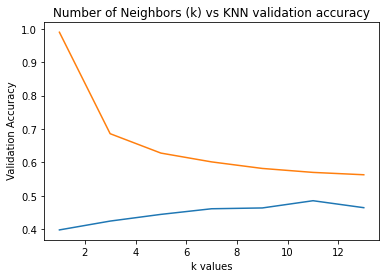

In [ ]:
plt.plot(np.arange(1, 14, 2), acc_val_knn)
plt.plot(np.arange(1, 14, 2), train_acc)

plt.title('Number of Neighbors (k) vs KNN validation accuracy')
plt.xlabel('k values')
plt.ylabel(' Validation Accuracy')

We choose K=11, based on the accuracy plot, since the validation accuracy is 

In [ ]:
# Model KNN with K = 11, if focus is to increase prediction recall of Diabetic cases K = 189
k = 11
KNN_model = KNN(n_neighbors = k)
KNN_model.fit(train_dwn_x, train_dwn_y)
KNN_predict = KNN_model.predict(test_x)

#### KNN Model Performance

In [ ]:
cm_KNN = metrics.confusion_matrix(test_y, KNN_predict, labels = [0,1,2])
cm_KNN =  pd.DataFrame(cm_KNN, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Actual')
cm_KNN

	   Confusion Matrix 
 
   	  	 Actual


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,13055,4899,3455
Pre-diabetes,104,189,180
Diabetes,732,1276,1478


In [ ]:
print('Precision for KNN classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, KNN_predict, labels = [0,1,2], average = None))
print('Recall for KNN classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, KNN_predict, labels = [0,1,2], average = None))
print('F1-score for KNN classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, KNN_predict, labels = [0,1,2], average = None))


Precision for KNN classifier for predicting 0, 1, 2 labels: [0.93981715 0.0296983  0.28906708]
Recall for KNN classifier for predicting 0, 1, 2 labels: [0.60979028 0.39957717 0.42398164]
F1-score for KNN classifier for predicting 0, 1, 2 labels: [0.73966006 0.05528741 0.3437609 ]


## Ada-Boost

In [ ]:
acc_val_ada = []
acc_train_ada =[]
for estimators in range(50,2000, 100):
    ada_model = AdaBoost(n_estimators = estimators, random_state = 32)
    ada_model.fit(train_x_small, train_y_small)
    acc_val_ada.append(ada_model.score(val_x, val_y))
    acc_train_ada.append(ada_model.score(train_x_small, train_y_small))
    

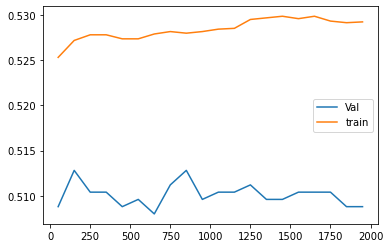

In [ ]:
plt.plot(range(50,2000, 100), acc_val_ada)
plt.plot(range(50,2000, 100), acc_train_ada)
plt.legend(['Val','train'])

We chose number of estimators = 850 based on the above plot, since it gives best validation accuracy.

In [ ]:
estimators = 850
ada_model = AdaBoost(n_estimators = estimators, random_state = 32)
ada_model.fit(train_dwn_x, train_dwn_y)
ada_predict = ada_model.predict(test_x)

#### Ada Boost Model Performance

In [ ]:
cm_ada = metrics.confusion_matrix(test_y, ada_predict, labels = [0,1,2])
cm_ada =  pd.DataFrame(cm_ada, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_ada


	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,13850,3802,3757
Pre-diabetes,113,152,208
Diabetes,590,841,2055


In [ ]:
print('Precision for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, ada_predict, labels = [0,1,2], average = None))
print('Recall for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, ada_predict, labels = [0,1,2], average = None))
print('F1-score for Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, ada_predict, labels = [0,1,2], average = None))


Precision for Ada Boost classifier for predicting 0, 1, 2 labels: [0.95169381 0.03169969 0.34136213]
Recall for Ada Boost classifier for predicting 0, 1, 2 labels: [0.64692419 0.32135307 0.58950086]
F1-score for Ada Boost classifier for predicting 0, 1, 2 labels: [0.77025749 0.05770691 0.43235851]


#### Ada Boost Model Performance on One Hot Encoded labels

In [ ]:
enc = preprocessing.OneHotEncoder().fit(np.array(train_dwn_y).reshape([-1,1]))
train_y_ohe = enc.transform(np.array(train_dwn_y).reshape([-1,1])).toarray()
test_y_ohe = enc.transform(np.array(test_y).reshape([-1,1])).toarray()

In [ ]:
ada_model_0 = AdaBoost(n_estimators = estimators, random_state = 32)
ada_model_1 = AdaBoost(n_estimators = estimators, random_state = 32)
ada_model_2 = AdaBoost(n_estimators = estimators, random_state = 32)

ada_model_0.fit(train_dwn_x, train_y_ohe[:,0])
ada_model_1.fit(train_dwn_x, train_y_ohe[:,1])
ada_model_2.fit(train_dwn_x, train_y_ohe[:,2])

pred_0 = ada_model_0.predict_proba(test_x) # prediction using model_0
pred_1 = ada_model_1.predict_proba(test_x) # prediction using model_1
pred_2 = ada_model_2.predict_proba(test_x) # prediction using model_2

In [ ]:
#concatenate probability prediction of each label by each model
pred_prob = np.concatenate([np.array(pred_0[:,1]).reshape([-1,1]), np.array(pred_1[:,1]).reshape([-1,1]), np.array(pred_2[:,1]).reshape([-1,1])], axis=1)
normalized_ada_multi_predict = np.divide(pred_prob,np.sum(pred_prob, axis = 1).reshape([-1,1]))
predict_multi_ada = np.argmax(normalized_ada_multi_predict, axis = 1)

In [ ]:
cm_ada_p = metrics.confusion_matrix(test_y, predict_multi_ada, labels = [0,1,2])
cm_ada_p =  pd.DataFrame(cm_ada_p, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_ada_p

	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,14270,3365,3774
Pre-diabetes,125,134,214
Diabetes,642,781,2063


In [ ]:
print('Precision for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))
print('Recall for Multiple Binary Ada Boosbt classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))
print('F1-score for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, predict_multi_ada, labels = [0,1,2], average = None))


Precision for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels: [0.94899249 0.03130841 0.34093538]
Recall for Multiple Binary Ada Boosbt classifier for predicting 0, 1, 2 labels: [0.66654211 0.2832981  0.59179575]
F1-score for Multiple Binary Ada Boost classifier for predicting 0, 1, 2 labels: [0.78307633 0.05638544 0.43263081]


## Random Forrest

In [78]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,12,14],
}

In [ ]:
rfc = RandomForest(random_state=32)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_dwn_x, train_dwn_y)
predict_rfc = CV_rfc.predict(test_x)

In [ ]:
print('Best RF model:', CV_rfc.best_estimator_)

Best RF model: RandomForestClassifier(max_depth=10, n_estimators=500, random_state=32)


#### Model Performance

In [ ]:
cm_rfc = metrics.confusion_matrix(test_y, predict_rfc, labels = [0,1,2])
cm_rfc =  pd.DataFrame(cm_rfc, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_rfc


	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,13388,4001,4020
Pre-diabetes,103,143,227
Diabetes,531,793,2162


In [ ]:
print('Precision for Random Forest classifier for predicting 0, 1, 2 labels:', metrics.precision_score(test_y, predict_rfc, labels = [0,1,2], average = None))
print('Recall for Random Forest classifier for predicting 0, 1, 2 labels:', metrics.recall_score(test_y, predict_rfc, labels = [0,1,2], average = None))
print('F1-score for  Random Forest classifier for predicting 0, 1, 2 labels:', metrics.f1_score(test_y, predict_rfc, labels = [0,1,2], average = None))


Precision for Random Forest classifier for predicting 0, 1, 2 labels: [0.95478534 0.02896496 0.33733812]
Recall for Random Forest classifier for predicting 0, 1, 2 labels: [0.62534448 0.30232558 0.62019507]
F1-score for  Random Forest classifier for predicting 0, 1, 2 labels: [0.75572239 0.05286506 0.43698838]


## SVM

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train_data_downsampled.csv')
test = pd.read_csv('/content/drive/MyDrive/test_BMI_processed.csv')
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
#print(ohe_data.loc[:,'Diabetes_012_1'])

ohe_data = pd.get_dummies(y_train, columns = ['Diabetes_012'])
ohe_test = pd.get_dummies(y_test, columns = ['Diabetes_012'])

In [ ]:
pipe = Pipeline([('kernelize', Nystroem(random_state=32)), ('svc', svm.LinearSVC(dual = False, class_weight='balanced'))])
param_grid = dict(kernelize__n_components=[300, 400, 500, 600],
                  kernelize__gamma=[0.00005, 0.0001, 0.0005, 0.001],
                  svc__C=[50, 100, 150, 200])
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1)
%time grid_search.fit(X_val, y_val)

CPU times: user 2.06 s, sys: 265 ms, total: 2.33 s
Wall time: 1min 7s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kernelize', Nystroem(random_state=32)),
                                       ('svc',
                                        LinearSVC(class_weight='balanced',
                                                  dual=False))]),
             n_jobs=-1,
             param_grid={'kernelize__gamma': [5e-05, 0.0001, 0.0005, 0.001],
                         'kernelize__n_components': [300, 400, 500, 600],
                         'svc__C': [50, 100, 150, 200]},
             scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
pd.DataFrame(grid_search.cv_results_)

{'kernelize__gamma': 0.0005, 'kernelize__n_components': 400, 'svc__C': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernelize__gamma,param_kernelize__n_components,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214480,0.009644,0.012807,0.001083,5e-05,300,50,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.491472,0.467636,0.489056,0.482721,0.010712,45
1,0.236237,0.013572,0.013990,0.002136,5e-05,300,100,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.498577,0.455469,0.488466,0.480837,0.018407,49
2,0.244001,0.007288,0.013144,0.000519,5e-05,300,150,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.499540,0.450879,0.486920,0.479113,0.020619,56
3,0.274599,0.012876,0.013065,0.000189,5e-05,300,200,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.504318,0.459316,0.492273,0.485302,0.019022,36
4,0.313843,0.004781,0.018472,0.002294,5e-05,400,50,"{'kernelize__gamma': 5e-05, 'kernelize__n_comp...",0.491472,0.467636,0.489056,0.482721,0.010712,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.227567,0.013408,0.021207,0.001265,0.001,500,200,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.476569,0.482243,0.474031,0.477614,0.003433,62
60,1.072656,0.012037,0.030712,0.003142,0.001,600,50,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.490104,0.486532,0.492918,0.489851,0.002613,15
61,1.347637,0.024969,0.027305,0.001964,0.001,600,100,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.488511,0.492153,0.494908,0.491857,0.002620,5
62,1.572036,0.101450,0.029572,0.001799,0.001,600,150,"{'kernelize__gamma': 0.001, 'kernelize__n_comp...",0.476821,0.480225,0.478998,0.478681,0.001408,58


In [ ]:
clf = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time clf.fit(data_transformed, y_train)

CPU times: user 15.7 s, sys: 91.8 ms, total: 15.8 s
Wall time: 15.6 s


LinearSVC(C=100, class_weight='balanced', dual=False)

In [ ]:
y_pred = clf.predict(test_transformed)
print('train accuracy: ', clf.score(data_transformed, y_train))
print('test accuracy: ', clf.score(test_transformed, y_test))
print('weighted f1: ', metrics.f1_score(y_test, y_pred, average='weighted'))
print(metrics.f1_score(y_test, y_pred, labels=[0,1,2], average=None))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.multilabel_confusion_matrix(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred, labels = [0,1,2], average = None))
print('recall: ', metrics.recall_score(y_test, y_pred, labels = [0,1,2], average = None))

train accuracy:  0.5439159094958133
test accuracy:  0.6348943550930306
weighted f1:  0.711513341163448
[0.77127926 0.05658537 0.43332987]
[[13873  3690  3846]
 [  111   145   217]
 [  581   817  2088]]
[[[ 3267   692]
  [ 7536 13873]]

 [[20388  4507]
  [  328   145]]

 [[17819  4063]
  [ 1398  2088]]]
precision:  [0.95248884 0.03116939 0.339457  ]
recall:  [0.64799851 0.30655391 0.5989673 ]


In [ ]:
model_0 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_0.fit(data_transformed, ohe_data.loc[:,0])

model_1 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_1.fit(data_transformed, ohe_data.loc[:,1])

model_2 = svm.LinearSVC(dual = False, C=100, class_weight='balanced')
feature_map_nystroem = Nystroem(random_state=32,
                                n_components=400,
                                gamma=0.0005)
data_transformed = feature_map_nystroem.fit_transform(X_train)
test_transformed = feature_map_nystroem.transform(X_test)
%time model_2.fit(data_transformed, ohe_data.loc[:,2])

CPU times: user 5.04 s, sys: 108 ms, total: 5.15 s
Wall time: 5.05 s
CPU times: user 7.5 s, sys: 106 ms, total: 7.61 s
Wall time: 7.5 s
CPU times: user 6.82 s, sys: 109 ms, total: 6.92 s
Wall time: 6.8 s


LinearSVC(C=100, class_weight='balanced', dual=False)

In [ ]:
pred_0 = model_0.predict(test_transformed)
pred_1 = model_1.predict(test_transformed)
pred_2 = model_2.predict(test_transformed)

pred_prob = np.concatenate((pred_0.reshape(-1, 1), pred_1.reshape(-1, 1), pred_2.reshape(-1, 1)), axis=1)
#normalized_multi_predict = np.divide(pred_prob,np.sum(pred_prob, axis = 1).reshape([-1,1]))
y_pred = np.argmax(pred_prob, axis = 1)
y_pred

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
print('weighted f1: ', metrics.f1_score(y_test, y_pred, average='weighted'))
print(metrics.f1_score(y_test, y_pred, labels=[0,1,2], average=None))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.multilabel_confusion_matrix(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred, labels = [0,1,2], average = None))
print('recall: ', metrics.recall_score(y_test, y_pred, labels = [0,1,2], average = None))

weighted f1:  0.7113355952193638
[0.79487806 0.06719717 0.28566633]
[[14650  5214  1545]
 [  131   266    76]
 [  671  1964   851]]
[[[ 3157   802]
  [ 6759 14650]]

 [[17717  7178]
  [  207   266]]

 [[20261  1621]
  [ 2635   851]]]
precision:  [0.94809733 0.03573348 0.34425566]
recall:  [0.68429165 0.56236786 0.24411933]


### Summary - Model *Performance*

We can see over the past few models, that the multilabel classification is underperforming especially in predicing the pre-diabetes class. 

There are two reason:
> 1) the Prediabetic data available to us is relatively very small compared to the other labels. So the model is unable to capture the distribution of this class.                                
    
> 2) Another reason is that the features avaialble in the dataset might not be  good enough to estimate the probability of prediabetes. Let us look at the correlation between this class and the features

Text(0.5, 1.0, 'Correlation matrix of features for prediabetes class')

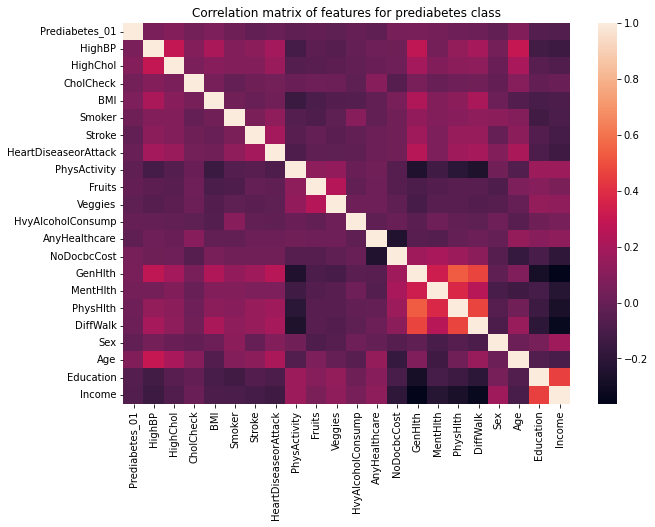

In [39]:
data_proc = train_dwn.copy()
data_proc['Diabetes_012'] = data_proc['Diabetes_012'].apply(lambda x: 1 if x==1 else 0) # convert class labels to 1-prediabetes, 0-no diabetes/diabetes
data_proc.rename(columns={'Diabetes_012':'Prediabetes_01'},inplace=True)
corr_prediabetes = data_proc.corr()

fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(corr_prediabetes)
plt.title("Correlation matrix of features for prediabetes class")

In [40]:
corr_prediabetes['Prediabetes_01']

Prediabetes_01          1.000000
HighBP                  0.061279
HighChol                0.091705
CholCheck               0.040269
BMI                     0.070715
Smoker                  0.020081
Stroke                 -0.015967
HeartDiseaseorAttack    0.002600
PhysActivity           -0.022293
Fruits                 -0.013385
Veggies                -0.030847
HvyAlcoholConsump      -0.004911
AnyHealthcare          -0.023448
NoDocbcCost             0.053084
GenHlth                 0.057689
MentHlth                0.044229
PhysHlth                0.026338
DiffWalk                0.012898
Sex                    -0.016298
Age                     0.082248
Education              -0.062641
Income                 -0.073844
Name: Prediabetes_01, dtype: float64

Now based on this observation, we think that the dataset is not good representation or the featurs in our dataset are not sufficient to estimate whether a person has prediabetes. We retrained our best models so far - Random Forest, SVM, DL, on a binary dataset with only no-diabetes and diabetes labels.

### Binary Classification - Diabetes vs No Diabetes

In [89]:
# Drop Prediabetes and use diabetes and no-diabetes dataset for binary prediction of diabtes status
train_50 = pd.read_csv('train_50.csv')
print('Class labels in train after removing prediabetes:\n', train_50.Diabetes_012.value_counts())
train_x_50 = train_50.iloc[:, 1:]
train_y_50 = train_50.iloc[:, 0]

# same with test - drop prediabetes
test_50 = pd.read_csv('test_50.csv')
test_50_x = test_50.iloc[:,1:]
test_50_y = test_50.iloc[:,0]
print('\n Class labels in test after removing prediabetes:\n',test_50.Diabetes_012.value_counts())


Class labels in train after removing prediabetes:
 1    31860
0    31860
Name: Diabetes_012, dtype: int64

 Class labels in test after removing prediabetes:
 0    21409
1     3486
Name: Diabetes_012, dtype: int64


### Logistic Regression

In [90]:
logistic_clf_model_50 = LogisticRegression(max_iter=10000)
logistic_clf_model_50.fit(train_x_50,train_y_50) # train logistic regression 
logistic_clf_50_predict = logistic_clf_model_50.predict(test_50_x)


cm_logistic_clf_50 = metrics.confusion_matrix(test_50_y, logistic_clf_50_predict, labels = [0,1])
cm_logistic_clf_50 =  pd.DataFrame(cm_logistic_clf_50, columns= ['No Diabetes', 'Diabetes'], index =  ['No Diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix for Upsampled \n \n  \033[0m', '\t  \t Predicted')
cm_logistic_clf_50


	   Confusion Matrix for Upsampled 
 
   	  	 Predicted


,No Diabetes,Diabetes
No Diabetes,15538,5871
Diabetes,797,2689


In [91]:
print('\n \nModel trained on Binary Data\n')
print('Precision for logistic regression classifier for predicting 0, 1 labels:', metrics.precision_score(test_50_y, logistic_clf_50_predict, labels = [0,1], average = None))
print('Recall for logistic regression classifier for predicting 0, 1 labels:', metrics.recall_score(test_50_y, logistic_clf_50_predict, labels = [0,1], average = None))
print('F1-score for logistic regression classifier for predicting 0, 1 labels:', metrics.f1_score(test_50_y, logistic_clf_50_predict, labels = [0,1], average = None))


 
Model trained on Binary Data

Precision for logistic regression classifier for predicting 0, 1 labels: [0.95120906 0.31413551]
Recall for logistic regression classifier for predicting 0, 1 labels: [0.72576954 0.7713712 ]
F1-score for logistic regression classifier for predicting 0, 1 labels: [0.82333616 0.44645525]


### Random Forest

In [92]:
# Random Forest 

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,12,14],
}

rfc = RandomForest(random_state=32)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_x_50, train_y_50)
predict_rfc = CV_rfc.predict(test_50_x)
CV_rfc.best_estimator_


RandomForestClassifier(max_depth=12, n_estimators=500, random_state=32)

In [93]:
cm_rfc = metrics.confusion_matrix(test_50_y, predict_rfc, labels = [0,1])
cm_rfc =  pd.DataFrame(cm_rfc, columns= ['No Diabetes', 'Diabetes'], index =  ['No Diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_rfc

	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Diabetes
No Diabetes,15252,6157
Diabetes,747,2739


In [94]:
print('Precision for Random Forest classifier for predicting 0, 1 labels:', metrics.precision_score(test_50_y, predict_rfc, labels = [0,1], average = None))
print('Recall for Random Forest classifier for predicting 0, 1 labels:', metrics.recall_score(test_50_y, predict_rfc, labels = [0,1], average = None))
print('F1-score for  Random Forest classifier for predicting 0, 1 labels:', metrics.f1_score(test_50_y, predict_rfc, labels = [0,1], average = None))


Precision for Random Forest classifier for predicting 0, 1 labels: [0.95330958 0.30789119]
Recall for Random Forest classifier for predicting 0, 1 labels: [0.71241067 0.78571429]
F1-score for  Random Forest classifier for predicting 0, 1 labels: [0.81544055 0.44241641]


## Comparison with AutoML

In [1]:
%pip install auto-sklearn

In [5]:
import autosklearn.classification
import pandas as pd
import sklearn

### Multiclass classification on the downsampled no diabetes, prediabetes, diabetes data

In [7]:
train = pd.read_csv('train_data_downsampled.csv')
train_x = train.iloc[:, 1:]
train_y = train.iloc[:, 0]

test = pd.read_csv('test_BMI_processed.csv')
test_x = test.iloc[:, 1:]
test_y = test.iloc[:, 0]

In [10]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=30
)
automl.fit(train_x, train_y)

AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=300)

In [13]:
print(automl.leaderboard())

          rank  ensemble_weight                type      cost   duration
model_id                                                                
3            1             0.40  passive_aggressive  0.480447   1.286698
18           2             0.24       random_forest  0.484090   5.108541
6            3             0.20       random_forest  0.487491   7.426687
12           4             0.02   gradient_boosting  0.489434   5.302798
2            5             0.06       random_forest  0.509109  12.023860
9            6             0.02         gaussian_nb  0.516638   1.139938
10           7             0.04         gaussian_nb  0.517124   1.749648
5            8             0.02       random_forest  0.535827   7.322236


In [12]:
predict_auto = automl.predict(test_x)

cm_auto = sklearn.metrics.confusion_matrix(test_y, predict_auto, labels = [0,1,2])
cm_auto =  pd.DataFrame(cm_auto, columns= ['No Diabetes', 'Pre-diabetes', 'Diabetes'], index =  ['No Diabetes', 'Pre-diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_auto


	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Pre-diabetes,Diabetes
No Diabetes,14102,3229,4078
Pre-diabetes,111,132,230
Diabetes,618,668,2200


In [14]:
print('Precision for AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.precision_score(test_y, predict_auto, labels = [0,1,2], average = None))
print('Recall for AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.recall_score(test_y, predict_auto, labels = [0,1,2], average = None))
print('F1-score for  AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.f1_score(test_y, predict_auto, labels = [0,1,2], average = None))


Precision for AutoML for predicting 0, 1, 2 labels: [0.9508462  0.03276247 0.33804548]
Recall for AutoML for predicting 0, 1, 2 labels: [0.65869494 0.27906977 0.63109581]
F1-score for  AutoML for predicting 0, 1, 2 labels: [0.77825607 0.0586406  0.44026416]


### Binary classification on the downsampled no diabetes and diabetes data (drop prediabetes)

In [15]:
train = pd.read_csv('train_50.csv')
train_x = train.iloc[:, 1:]
train_y = train.iloc[:, 0]

test = pd.read_csv('test_50.csv')
test_x = test.iloc[:, 1:]
test_y = test.iloc[:, 0]

In [16]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=30
)
automl.fit(train_x, train_y)

AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=300)

In [17]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
17           1             0.62  gradient_boosting  0.246909   8.155366
13           2             0.38      random_forest  0.249667  22.164260


In [21]:
predict_auto = automl.predict(test_x)

cm_auto = sklearn.metrics.confusion_matrix(test_y, predict_auto, labels = [0,1])
cm_auto =  pd.DataFrame(cm_auto, columns= ['No Diabetes', 'Diabetes'], index =  ['No Diabetes', 'Diabetes'])
print('\t \033[1m  Confusion Matrix \n \n  \033[0m', '\t  \t Predicted')
cm_auto


	   Confusion Matrix 
 
   	  	 Predicted


,No Diabetes,Diabetes
No Diabetes,15267,6142
Diabetes,738,2748


In [22]:
print('Precision for AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.precision_score(test_y, predict_auto, labels = [0,1], average = None))
print('Recall for AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.recall_score(test_y, predict_auto, labels = [0,1], average = None))
print('F1-score for  AutoML for predicting 0, 1, 2 labels:', sklearn.metrics.f1_score(test_y, predict_auto, labels = [0,1], average = None))

Precision for AutoML for predicting 0, 1, 2 labels: [0.95388941 0.30911136]
Recall for AutoML for predicting 0, 1, 2 labels: [0.71311131 0.78829604]
F1-score for  AutoML for predicting 0, 1, 2 labels: [0.81611162 0.44408533]
